In [1]:
import pandas as pd
import pynbody
import numpy as np
import h5py
import pynbody.plot.sph as sph
from pynbody import units
from pynbody.analysis import profile
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.colors as colors


In [2]:
import sys
sys.path.append('/home/vadilloj/MAP2023/Vadillo-Justice-League-Code')
from Runnable_Modules import Base as base, IonUtils as ions, TrackingUtils as tracking


from Runnable_Modules.IonUtils import HI_factor, OVI_factor
from Runnable_Modules.Base import simulations

In [121]:
import importlib
importlib.reload(base)
importlib.reload(tracking)

<module 'Runnable_Modules.TrackingUtils' from '/home/vadilloj/MAP2023/Vadillo-Justice-League-Code/Runnable_Modules/TrackingUtils.py'>

In [ ]:
subsims['

In [74]:
def getHaloChars(h1, subsims,edge):

    def getMassProfiles(subsnap, mass, ranges, nbins, totalMass, binAreas):
        mass, bins = np.histogram(subsnap['r'], bins = nbins, weights = subsnap[mass], range= ranges)
        fraction = mass/totalMass
        density = mass/binAreas
        return fraction, density
    nbins = 100   
    
    ranges = (0.1, edge)

    total_mass, bins = np.histogram(h1.g['r'], bins = nbins, weights = h1.g['mass'], range= ranges)
    total_OVI, bins = np.histogram(h1.g['r'], bins = nbins, weights = h1.g['OVI_mass'], range= ranges)
    total_HI, bins = np.histogram(h1.g['r'], bins = nbins, weights = h1.g['HI_mass'], range= ranges)
    bin_areas = np.zeros(nbins)
    for binNum in range(nbins):
        outer_shell = (4/3)*np.pi*(bins[binNum+1]**3)
        inner_shell = (4/3)*np.pi*(bins[binNum]**3)
        bin_areas[binNum] = outer_shell - inner_shell
    
    HI_Ratios,OVI_Ratios, Mass_Ratios  = {}, {}, {}
    HI_Density, OVI_Density,Mass_Density= {}, {}, {}
    rmin = str(ranges[0])+ " kpc"
    rmax = str(ranges[1])+ " kpc"

    
    profiles = {}
    # HaloCharachteristics['all_gas']['profile'] = allProf
    ##add a halo charachteristic of all of the gas to the halo Halo CHarachteristics array
    for halo in subsims:
        haloProf = profile.Profile(subsims[halo],rmin = rmin, nbins = nbins, rmax = rmax, ndim=3)
    
        HI_Ratios[halo], HI_Density[halo] = getMassProfiles(subsims[halo],"HI_mass", ranges, nbins, total_HI, bin_areas)
        OVI_Ratios[halo], OVI_Density[halo]= getMassProfiles(subsims[halo],"OVI_mass", ranges, nbins, total_OVI, bin_areas)
        Mass_Ratios[halo], Mass_Density[halo] = getMassProfiles(subsims[halo],"mass", ranges, nbins, total_mass, bin_areas)
        profiles[halo] = haloProf
    indexes = list(subsims.keys())
    indexes.insert(0, indexes.pop(indexes.index('local')))
    
    HaloChars = pd.DataFrame(pd.Series(profiles), index = indexes, columns  = ['profiles'])##data frame to store halo data
    HaloChars['Mass_Ratios']  = Mass_Ratios
    HaloChars['HI_Ratios']  = HI_Ratios
    HaloChars['OVI_Ratios']  = OVI_Ratios
    HaloChars['Mass_Density']  = Mass_Density
    HaloChars['HI_Density']  = HI_Density
    HaloChars['OVI_Density']  = OVI_Density

    rbins = (bins[0:-1] + bins[1:])/2
    return HaloChars, rbins

In [84]:
def makeStackplot(HaloChars, column , ax, rbins, cmapN, local_color = 'black',dwarfColor = 'white',cmap_end = 0.8):

    labels = list(HaloChars.index)
    nSources  = len(labels)

    cmap = mpl.colormaps[cmapN]
    segmentedCmap = cmap(np.linspace(0.2,cmap_end, nSources))
    segmentedCmap[0] = colors.to_rgba(local_color)
    segmentedCmap[-1] = colors.to_rgba(dwarfColor)
    values = []
    for label in labels:
        values.append(HaloChars[column][label])
    ax.stackplot(rbins, values, labels = labels, colors = segmentedCmap)

In [185]:
def make_all_stacks(sHaloChars, filename,edge ):
    plots_filepath  =  '/home/vadilloj/MAP2023/Vadillo-Justice-League-Code/MassFracs-Divided-By-Source-c/Data/'
    rows = 3
    cols = 2
    cmaps = ['bone', 'BuPu_r', 'YlOrRd_r']
    cmap_end = [0.8,0.8,0.8]
    ions = ["Mass", "HI", "OVI"]
    values = ["Density", "Ratios"]
    localC = ['black','Indigo', 'maroon']  
    smallsColors= ['burlywood', 'lightskyblue', 'lightcoral']
    yranges = [(10**1, 10**7), (10**-3.5, 10**3.5), (10**-3, 10**-1)]
    fig, axs = plt.subplots(rows,cols, figsize = (11,13))
    for row in (range(rows)):
        for col in range(cols):
            ax = axs[row, col]
            Hcolumn = ions[row] + '_' + values[col]
            makeStackplot(sHaloChars, Hcolumn, ax, rbins,
                          cmapN = cmaps[row],local_color = localC[row],dwarfColor =smallsColors[row], cmap_end = cmap_end[row])
            
            ax.set_xlim(1,edge)
    
            if (col == 0):
                ax.set_yscale("log")
                ax.set_title(ions[row] + " Log Density(Msol/kpc**3) Profile  divided by source")
                ax.set_ylabel('Log '+ ions[row]+ ' mass')
                ax.legend(loc = 'upper right')
                median = np.median(sHaloChars[Hcolumn]['local'])
                ax.set_ylim(yranges[row])
                

                    
                    
            else:
                ax.axhline(1,color = 'black', linestyle = '--')
                ax.set_title("fraction of total " +ions[row] +" divided by source")
                ax.set_ylabel('fraction of '+ ions[row]+ ' mass')
                ax.legend(loc = 'lower left')
                
    
    
    fig.supxlabel('radius (kpc)')
    name = filename + ' Mass Divided by Source'
    fig.suptitle(name, fontsize = 18)
    fig.tight_layout()
    fig.subplots_adjust(top=0.93)
    fig.savefig(plots_filepath+ name + '.png')


In [186]:
def findMassRatios(simulations,filename, HaloChars):

    mass_inhalo = {}
    satmass = {}
    mean_vr ={}
    pos = {}

    smallMass,smallOVI, smallHI = 0, 0 , 0
    haloMass,haloOVI, haloHI = 0, 0 , 0
    for haloKey in list(simulations['Halo keys'][filename]):
        subsnap = h[int(haloKey.split('_')[1])].g
        simMass = np.sum(subsnap['mass'])
        
        halo = "h"+(haloKey.split('_')[1]) 
        satmass[halo] = simMass
        mean_vr[halo] = np.mean(subsnap['vr'])
        pos[halo] = np.mean(subsnap['pos'], axis = 0)

        haloMass+= simMass
        if halo in list(HaloChars.index):
            mass_inhalo[halo] = simMass/np.sum(HaloChars["profiles"][halo]["mass"])
        else:
            smallMass+= simMass
    mass_inhalo["Dwarf Sattelites"] = smallMass/np.sum(HaloChars["profiles"]["Dwarf Sattelites"]["mass"])
    satmass["Dwarf Sattelites"]  = smallMass
    mean_vr["Dwarf Sattelites"],mean_vr["halos"] = 0, 0
    pos["Dwarf Sattelites"],pos["halos"] = 0, 0
    satmass['halos'] = haloMass
    mass_inhalo['halos'] =          haloMass/ np.sum(HaloChars["profiles"]['halos']["mass"] )

    HaloChars['MVir'] = satmass
    HaloChars['pos'] = pos
    HaloChars['mean vr'] = mean_vr
    HaloChars['Mvir/Mtotal'] = mass_inhalo
    return HaloChars
    
    

In [178]:
HaloChars

,Mass_Ratios,HI_Ratios,OVI_Ratios,Mass_Density,HI_Density,OVI_Density,MVir,pos,mean vr,Mvir/Mtotal
local,"[0.9375769756535733, 0.953202904849825, 0.9600...","[0.9366579142685311, 0.9518748160776909, 0.958...","[0.9316344504687396, 0.9543741916449991, 0.959...","[10231077.668726847, 3155638.2073895275, 23682...","[3189354.542331212, 1204499.7493546424, 960858...","[1619.981725233334, 405.8097542615653, 251.446...",NaN,NaN,NaN,NaN
h2,"[0.00030560546406010303, 0.0002341367240614409...","[0.00025316450229026196, 0.0002234805774582983...","[0.0001761071190412844, 0.00013129984775434373...","[3334.8443060972777, 775.1243606603425, 636.02...","[862.0344130300964, 282.7917022149484, 308.651...","[0.3062255956580738, 0.05583005011894839, 0.08...",8252345353.672479,"[-60.13165517546667, -163.24661311812238, 84.4...",12.320149142341059,0.7792029698079234
h4,"[0.0, 0.0, 0.0, 0.0, 3.816739795564414e-06, 8....","[0.0, 0.0, 0.0, 0.0, 3.5785359972006313e-06, 1...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 5.737834675216138, 2.7161...","[0.0, 0.0, 0.0, 0.0, 2.4100673578073875, 1.736...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",970641291.0114958,"[65.04164803340795, -235.44456260184967, 5.144...",41.647114139057024,0.702860039026018
h10,"[0.012142508675581608, 0.006583900468026312, 0...","[0.012073983735477793, 0.006696274053775125, 0...","[0.00996848803207666, 0.006375498213801424, 0....","[132502.13324240939, 21796.416864494244, 11684...","[41112.35733362877, 8473.446595233614, 5009.20...","[17.333803437653415, 2.7109276278503827, 1.148...",1139459917.4270222,"[-25.43097366826903, -132.81535421804338, -6.2...",51.83741791714037,0.5390028570374483
h23,"[0.01586278684126777, 0.01703179767191091, 0.0...","[0.01596060180032104, 0.017471851268613604, 0....","[0.016537146065254128, 0.017642756825073456, 0...","[173098.75181430945, 56384.838107976255, 37372...","[54346.43435426088, 22108.832084164544, 15992....","[28.755779050191894, 7.501882253688171, 4.3033...",377541129.3180728,"[181.69330003873839, 89.56851152993009, -161.3...",-26.812347429110595,0.2668299403724525
Dwarf Sattelites,"[0.03553675717168411, 0.024094310975786827, 0....","[0.03625463137980803, 0.024970903624547288, 0....","[0.04403903066738366, 0.023054845400823455, 0....","[387786.1041379981, 79765.73288758135, 51843.2...","[123448.34918950434, 31598.11211401064, 21392....","[76.57770152473095, 9.803158162230222, 5.29382...",1343951252.0345366,0,0,0.504659817202658
halos,"[0.06242302434642697, 0.04679709515017535, 0.0...","[0.0633420857314689, 0.04812518392230939, 0.04...","[0.06836554953126064, 0.045625808355000644, 0....","[681175.8682106319, 154924.72872184787, 98558....","[215682.1244671361, 60897.47411421855, 41409.1...","[118.87810806100364, 19.40056451507157, 10.498...",12083938943.463608,0,0,0.6694162226299243


In [177]:
HaloChars = findMassRatios(simulations,filename, HaloChars)
HaloChars= HaloChars.drop(columns=['profiles'])

sHaloChars = HaloChars.drop('halos')


/home/vadilloj/anaconda3/envs/conda-env-py311/lib/python3.11/site-packages/pynbody/halo/__init__.py:274: RuntimeWarning: Accessing multiple halos may be more efficient if you call load_all() on the halo catalogue
  warnings.warn("Accessing multiple halos may be more efficient if you call load_all() on the "
/home/vadilloj/anaconda3/envs/conda-env-py311/lib/python3.11/site-packages/numpy/_core/fromnumeric.py:3860: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/vadilloj/anaconda3/envs/conda-env-py311/lib/python3.11/site-packages/numpy/_core/_methods.py:145: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/vadilloj/anaconda3/envs/conda-env-py311/lib/python3.11/site-packages/pynbody/array/__init__.py:611: RuntimeWarning: Mean of empty slice.
  x = np.ndarray.mean(self, *args, **kwargs)
/home/vadilloj/anaconda3/envs/conda-env-py311/lib/python3.11/site-packages/pynbody/array/__init__.py:361: R

In [195]:
directory_path = '/home/vadilloj/MAP2023/Vadillo-Justice-League-Code/'

In [96]:
def readInData(filename):
    data_name = data_filepath + filename +"Halo Charachteristics.csv"
    return(pd.read_csv(data_name, index_col = 0))

In [197]:
Akins_Keys = list(simulations['Halo keys']['Sandra'])

In [198]:
Mitsuru_filepath = directory_path + "all-satellite-data.csv"
Mitsuru_Keys = pd.read_csv(Mitsuru_filepath, index_col = 0).index

In [ ]:
Mitsuru_

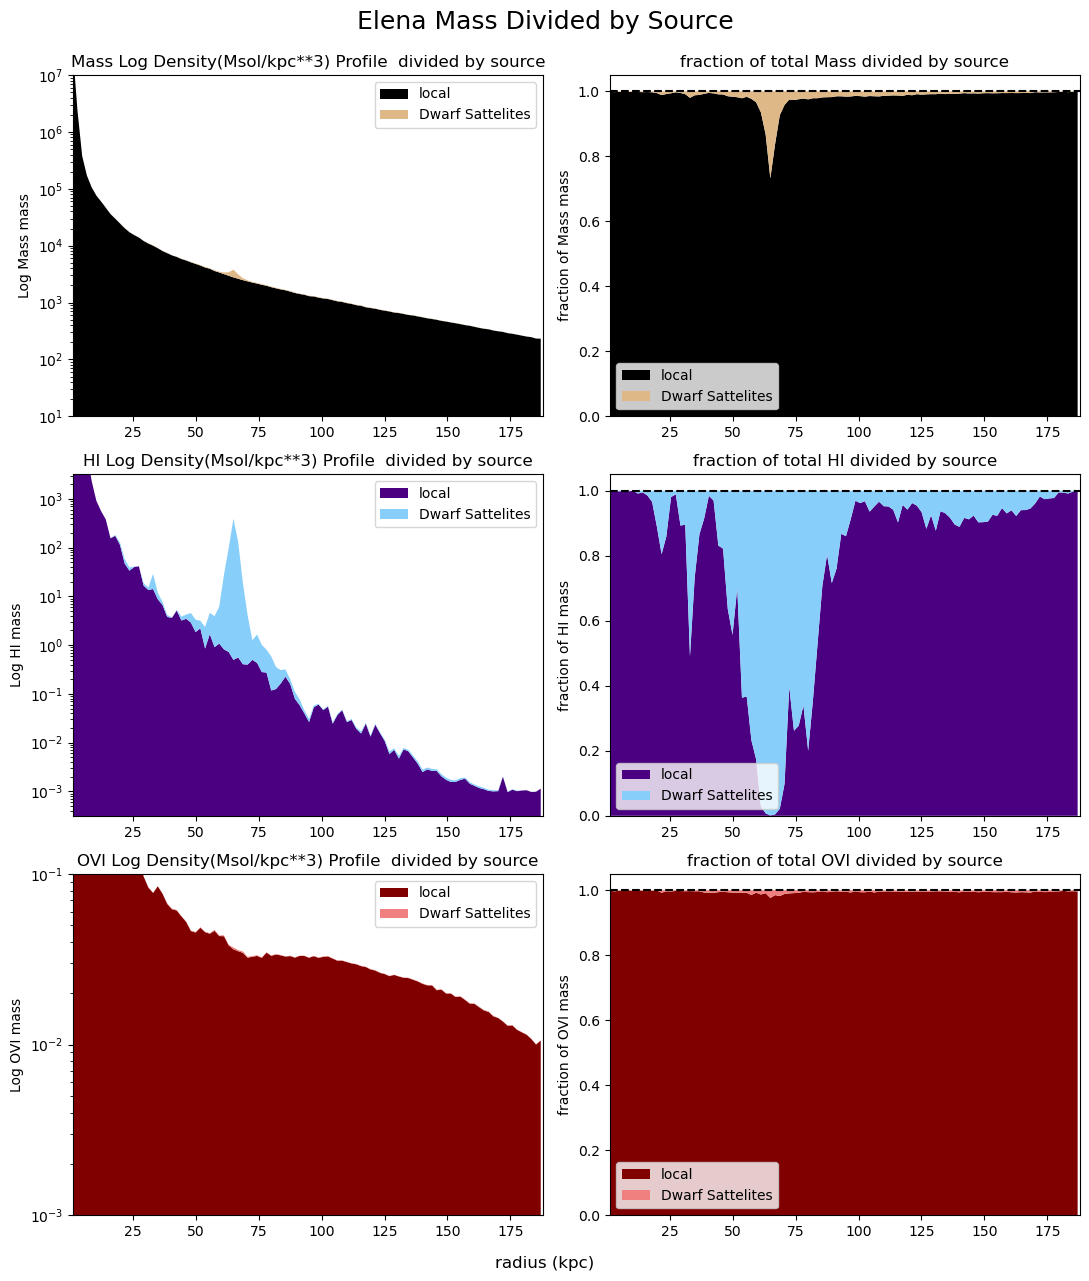

In [190]:
data_filepath  = '/home/vadilloj/MAP2023/Vadillo-Justice-League-Code/MassFracs-Divided-By-Source-c/Data/'
data_name = data_filepath + filename +"Halo Charachteristics.csv"
sHaloChars.to_csv(data_name)
make_all_stacks(sHaloChars, filename,edge )

In [85]:
HaloChars, rbins = getHaloChars(h1, subsims,edge)

# findMassRatios(simulations, filename, HaloChars)
# print(HaloChars)

# sHaloChars = HaloChars.drop('halos')

# data_name = data_filepath + filename +"Halo Charachteristics.csv"
# sHaloChars.to_csv(data_name)
make_all_stacks(sHaloChars, filename,edge )

/tmp/ipykernel_8362/2331304600.py:5: RuntimeWarning: invalid value encountered in divide
  fraction = mass/totalMass


NameError: name 'yranges' is not defined

In [ ]:
subsims = tracking.find_halo_particles(h1, simulations, filename, groupSmalls = True)##returns a dictionary of subsims for all halos in the simulations, 

<IndexedSubSnap "/home/vadilloj/MAP2023/Sims/h148.cosmo50PLK.3072g/h148.cosmo50PLK.3072g3HbwK1BH/snapshots_200crit_h148/h148.cosmo50PLK.3072g3HbwK1BH.004096:indexed" len=1>